<a href="https://colab.research.google.com/github/AydaAboufaresse/DATA-MINING/blob/main/FLOW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Required libraries
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import nltk
import seaborn as sns
import matplotlib.pyplot as plt

import re
from nltk.stem import PorterStemmer

# Ensure necessary NLTK resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

# Load the dataset
df = pd.read_csv('articles.csv')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [2]:
# Function to convert 'claps' from string to numeric
def convert_claps(value):
    if isinstance(value, str):
        if 'K' in value:
            return float(value.replace('K', '').replace(',', '').strip()) * 1000
        return float(value.replace(',', '').strip())
    return value

# Convert the 'claps' column to numeric
df['claps'] = df['claps'].apply(convert_claps)

# Fill NaN values with the mean of the column
df['claps'] = df['claps'].fillna(df['claps'].mean())

# Function to classify claps
def classify_claps(claps):
    if claps < 1000:
        return "Low"
    elif 1000 <= claps < 2000:
        return "Medium"
    else:
        return "High"

# Apply classification
df['claps_category'] = df['claps'].apply(classify_claps)

In [3]:
# Print the claps category distribution
print("\nClaps Category Distribution:\n", df['claps_category'].value_counts())


Claps Category Distribution:
 claps_category
High      172
Low       141
Medium     24
Name: count, dtype: int64


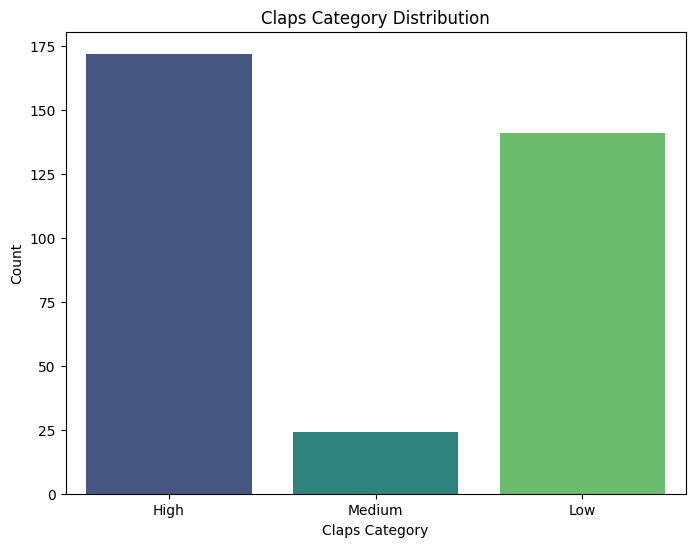

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Optionally, visualize the claps category distribution with a bar plot
plt.figure(figsize=(8, 6))
sns.countplot(data=df, hue='claps_category', palette='viridis', x='claps_category', legend=False)
plt.title('Claps Category Distribution')
plt.xlabel('Claps Category')
plt.ylabel('Count')
plt.show()

In [5]:
# --- Define Topics ---
topics_keywords = {
    "Neural Networks": ["network", "neural", "layer", "output", "neuron", "training", "input", "weights", "function", "layers"],
    "Artificial Intelligence": ["ai", "intelligence", "human", "people", "technology", "artificial", "google", "humans", "computer"],
    "Reinforcement Learning": ["table", "action", "policy", "learning", "reward", "actions", "network", "environment", "state", "rl"],
    "Machine Learning & Data Science": ["learning", "data", "machine", "course", "model", "ml", "science", "deep", "algorithms", "house"],
    "Computer Vision": ["image", "model", "cnn", "images", "pi", "object", "gtx", "training", "1080", "deep"],
}


In [6]:
# Classify topics based on keywords in both title and text
def classify_topic(row, keywords):
    combined_text = f"{row['title'].lower()} {row['text'].lower()}"
    for topic, words in keywords.items():
        if any(word in combined_text for word in words):
            return topic
    return "Other"

df['topic'] = df.apply(lambda row: classify_topic(row, topics_keywords), axis=1)

In [7]:
print("\nTopic Distribution:\n", df['topic'].value_counts())


Topic Distribution:
 topic
Neural Networks            306
Artificial Intelligence     31
Name: count, dtype: int64


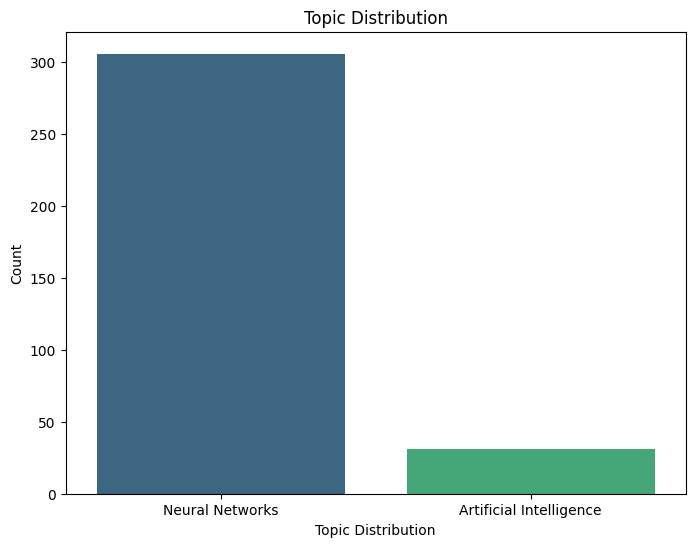

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Optionally, visualize the claps category distribution with a bar plot
plt.figure(figsize=(8, 6))
sns.countplot(data=df, hue='topic', palette='viridis', x='topic', legend=False)
plt.title('Topic Distribution')
plt.xlabel('Topic Distribution')
plt.ylabel('Count')
plt.show()

In [9]:
# --- Text Preprocessing ---
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()


# --- Text Preprocessing with Porter Stemmer ---
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()

    # Remove URLs and email addresses
    text = re.sub(r'http\S+|www\S+|https\S+|@[\w]+', '', text)

    # Remove punctuation and special characters (excluding spaces)
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stopwords and apply stemming
    tokens = [stemmer.stem(word) for word in tokens if word.isalpha() and word not in stop_words]

    # Remove words that are too long or too short (optional)
    tokens = [word for word in tokens if len(word) > 2 and len(word) < 20]

    return tokens
# Apply preprocessing to both text and title for GloVe
df['processed_text'] = df['text'].apply(preprocess_text)
df['processed_title'] = df['title'].apply(preprocess_text)

# --- Combine Processed Text and Title ---
# Create a combined tokens column for each row
df['combined_processed'] = df.apply(lambda row: row['processed_text'] + row['processed_title'], axis=1)

In [10]:
# --- Load GloVe Embeddings ---
def load_glove_embeddings(file_path):
    glove_embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.split()
            word = parts[0]
            vector = np.array(parts[1:], dtype=np.float32)
            glove_embeddings[word] = vector
    return glove_embeddings

glove_embeddings = load_glove_embeddings('glove.6B.200d.txt')  # Replace with actual file path
# --- Vectorize Text Using GloVe ---
def vectorize_text_glove(tokens, glove_model):
    vectors = [glove_model[word] for word in tokens if word in glove_model]
    return np.mean(vectors, axis=0) if vectors else np.zeros(200)  # Default vector size is 100 for 100d GloVe

# Create document vectors using GloVe embeddings
df['document_vector_glove'] = df['combined_processed'].apply(lambda x: vectorize_text_glove(x, glove_embeddings))

In [11]:


# --- Train-Test Split ---
X = np.vstack(df['document_vector_glove'].values)  # Use the GloVe vectors
y_claps = df['claps_category']  # Use claps category for classification

# Encode target labels for claps
label_encoder_claps = LabelEncoder()
y_encoded_claps = label_encoder_claps.fit_transform(y_claps)

In [12]:
# --- Train-Test Split with Stratification ---
X_train, X_test, y_train_claps, y_test_claps = train_test_split(
    X,
    y_encoded_claps,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded_claps  # Stratify by target labels
)

In [13]:
# --- Backward Elimination ---
n_features = X_train.shape[1]
features_to_keep = list(range(n_features))

best_accuracy = 0.0

while len(features_to_keep) > 0:
    accuracies = []

    # Evaluate model without each feature
    for feature in features_to_keep:
        temp_features = [f for f in features_to_keep if f != feature]
        X_train_temp = X_train[:, temp_features]
        X_test_temp = X_test[:, temp_features]

        # Train and evaluate SVM model
        svm_model_temp = SVC(kernel='linear', class_weight='balanced', random_state=42)
        svm_model_temp.fit(X_train_temp, y_train_claps)

        # Predict and calculate accuracy
        temp_predictions = svm_model_temp.predict(X_test_temp)
        temp_accuracy = accuracy_score(y_test_claps, temp_predictions)
        accuracies.append((feature, temp_accuracy))

    # Find the feature with the lowest accuracy when removed
    feature_to_remove, lowest_accuracy = min(accuracies, key=lambda x: x[1])

    # If the lowest accuracy is better than the best accuracy, keep it
    if lowest_accuracy < best_accuracy:
        break

    # Remove the feature and update the best accuracy
    features_to_keep.remove(feature_to_remove)
    best_accuracy = lowest_accuracy
    print(f"Removed feature {feature_to_remove}, New Best Accuracy for Claps Categories: {best_accuracy:.4f}")

# Final feature set after backward elimination
X_train_final = X_train[:, features_to_keep]
X_test_final = X_test[:, features_to_keep]


Removed feature 5, New Best Accuracy for Claps Categories: 0.5000


In [14]:
# --- Train the SVM model after backward elimination ---
svm_model = SVC(kernel='linear', class_weight='balanced', random_state=42)
svm_model.fit(X_train_final, y_train_claps)

# Final Predictions for claps categories
y_pred_claps = svm_model.predict(X_test_final)

# Calculate final accuracy for claps categories
final_accuracy_claps = accuracy_score(y_test_claps, y_pred_claps)
print(f"Final Accuracy for Claps Categories: {final_accuracy_claps:.4f}")

Final Accuracy for Claps Categories: 0.5000


In [15]:
# Classification Report for claps categories
print("\nClassification Report for Claps Categories:\n")
print(classification_report(
    y_test_claps,
    y_pred_claps,
    labels=sorted(set(y_train_claps)),  # Ensure that labels correspond to the training set
    target_names=label_encoder_claps.inverse_transform(sorted(set(y_train_claps))).tolist(),
))


Classification Report for Claps Categories:

              precision    recall  f1-score   support

        High       0.59      0.54      0.57        35
         Low       0.60      0.43      0.50        28
      Medium       0.19      0.60      0.29         5

    accuracy                           0.50        68
   macro avg       0.46      0.52      0.45        68
weighted avg       0.57      0.50      0.52        68



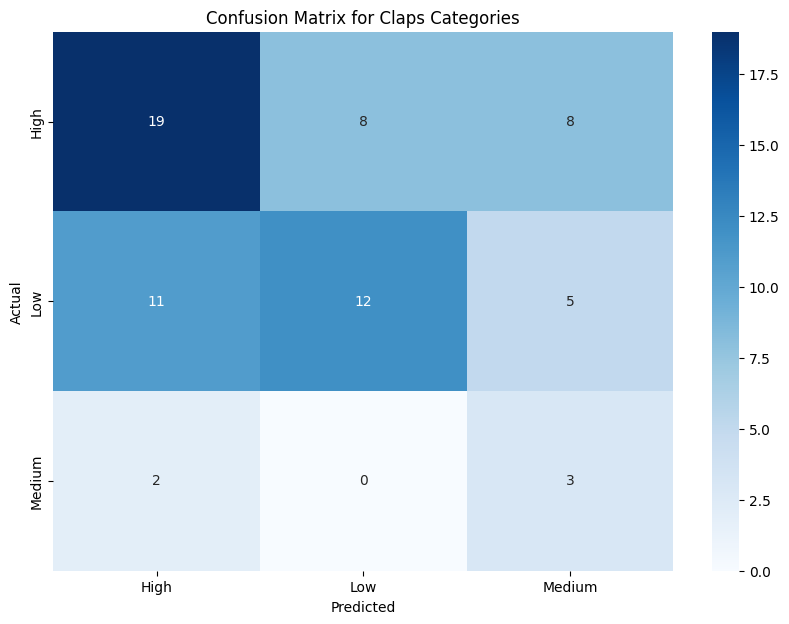

In [16]:
# --- Confusion Matrix Visualization for Claps Categories ---
conf_matrix_claps = confusion_matrix(y_test_claps, y_pred_claps)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_claps, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder_claps.classes_, yticklabels=label_encoder_claps.classes_)
plt.title('Confusion Matrix for Claps Categories')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [17]:
# --- Topic Classification ---
y_topic = df['topic']  # Use topic for classification

# Encode target labels for topics
label_encoder_topic = LabelEncoder()
y_encoded_topic = label_encoder_topic.fit_transform(y_topic)

# --- Train-Test Split with Stratification ---
X_train_topic, X_test_topic, y_train_topic, y_test_topic = train_test_split(
    X,
    y_encoded_topic,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded_topic  # Stratify by target labels
)


In [18]:

# --- Backward Elimination for Topic Classification ---
n_features_topic = X_train_topic.shape[1]
features_to_keep_topic = list(range(n_features_topic))

best_accuracy_topic = 0.0

while len(features_to_keep_topic) > 0:
    accuracies = []

    # Evaluate model without each feature
    for feature in features_to_keep_topic:
        temp_features = [f for f in features_to_keep_topic if f != feature]
        X_train_temp_topic = X_train_topic[:, temp_features]
        X_test_temp_topic = X_test_topic[:, temp_features]

        # Train and evaluate SVM model
        svm_model_temp_topic = SVC(kernel='linear', class_weight='balanced', random_state=42)
        svm_model_temp_topic.fit(X_train_temp_topic, y_train_topic)

        # Predict and calculate accuracy
        temp_predictions_topic = svm_model_temp_topic.predict(X_test_temp_topic)
        temp_accuracy_topic = accuracy_score(y_test_topic, temp_predictions_topic)
        accuracies.append((feature, temp_accuracy_topic))

    # Find the feature with the lowest accuracy when removed
    feature_to_remove_topic, lowest_accuracy_topic = min(accuracies, key=lambda x: x[1])

    # If the lowest accuracy is better than the best accuracy, keep it
    if lowest_accuracy_topic < best_accuracy_topic:
        break

    # Remove the feature and update the best accuracy
    features_to_keep_topic.remove(feature_to_remove_topic)
    best_accuracy_topic = lowest_accuracy_topic
    print(f"Removed feature {feature_to_remove_topic}, New Best Accuracy for Topic Classification: {best_accuracy_topic:.4f}")

# Final feature set after backward elimination for topic classification
X_train_final_topic = X_train_topic[:, features_to_keep_topic]
X_test_final_topic = X_test_topic[:, features_to_keep_topic]

Removed feature 14, New Best Accuracy for Topic Classification: 0.8088


In [19]:
# --- Train the SVM model after backward elimination for topic classification ---
svm_model_topic = SVC(kernel='linear', class_weight='balanced', random_state=42)
svm_model_topic.fit(X_train_final_topic, y_train_topic)

# Final Predictions for topic classification
y_pred_topic = svm_model_topic.predict(X_test_final_topic)

# Calculate final accuracy for topic classification
final_accuracy_topic = accuracy_score(y_test_topic, y_pred_topic)
print(f"Final Accuracy for Topic Classification: {final_accuracy_topic:.4f}")

Final Accuracy for Topic Classification: 0.8088


In [20]:
# Classification Report for topic classification
print("\nClassification Report for Topic Classification:\n")
print(classification_report(
    y_test_topic,
    y_pred_topic,
    labels=sorted(set(y_train_topic)),  # Ensure that labels correspond to the training set
    target_names=label_encoder_topic.inverse_transform(sorted(set(y_train_topic))).tolist(),
))


Classification Report for Topic Classification:

                         precision    recall  f1-score   support

Artificial Intelligence       0.27      0.67      0.38         6
        Neural Networks       0.96      0.82      0.89        62

               accuracy                           0.81        68
              macro avg       0.61      0.74      0.63        68
           weighted avg       0.90      0.81      0.84        68



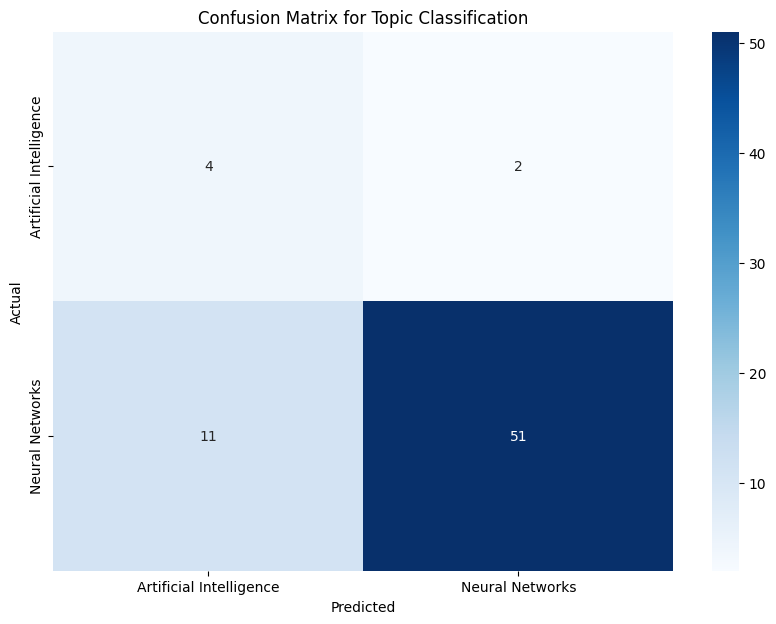

In [21]:

# --- Confusion Matrix Visualization for Topic Classification ---
conf_matrix_topic = confusion_matrix(y_test_topic, y_pred_topic)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_topic, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder_topic.classes_, yticklabels=label_encoder_topic.classes_)
plt.title('Confusion Matrix for Topic Classification')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [22]:
# Define example inputs for testing with titles and text
example_inputs = [
    {
        "title": "Cloud Services Explained: Navigating AWS, Azure, and Google Cloud",
        "text": "Cloud computing offers a variety of services that enhance flexibility and scalability for businesses. This article provides an overview of major cloud service providers, including AWS, Azure, and Google Cloud, and compares their offerings. We will discuss various cloud models, such as IaaS, PaaS, and SaaS, to help you choose the right solution for your needs."
    },
    {
        "title": "Deep Learning for Image Classification",
        "text": "Convolutional Neural Networks (CNNs) are widely used for image classification tasks. In this article, we explore how CNNs work, the training process, and their application in areas such as facial recognition, medical imaging, and autonomous vehicles."
    },
]

# Preprocess and vectorize the example inputs using GloVe
preprocessed_inputs = [
    preprocess_text(item["title"] + " " + item["text"]) for item in example_inputs
]
input_vectors_glove = np.vstack([vectorize_text_glove(tokens, glove_embeddings) for tokens in preprocessed_inputs])

# Check the shape of the training data to confirm dimensions
print(f"Shape of X_train during training: {X_train.shape}")  # Print the shape of the training data

# Ensure the input vectors for prediction have the same shape by applying features_to_keep
input_vectors_final_glove = input_vectors_glove[:, features_to_keep]  # Apply the same features_to_keep as for training

# Check the shape of the input vectors for prediction
print(f"Shape of input vectors for prediction: {input_vectors_final_glove.shape}")

# Make predictions for claps category
predictions_claps = svm_model.predict(input_vectors_final_glove)

# Make predictions for topics using GloVe vectors
predictions_topic = svm_model_topic.predict(input_vectors_final_glove)

# Decode predictions and display the results
predicted_claps = label_encoder_claps.inverse_transform(predictions_claps)  # Decoding claps predictions
predicted_topics = label_encoder_topic.inverse_transform(predictions_topic)  # Decoding topic predictions

# Print results for each input example
for item, clap, topic in zip(example_inputs, predicted_claps, predicted_topics):
    print(f"Title: {item['title']}\nPredicted Clap Category: {clap}\nPredicted Topic: {topic}\n")






Shape of X_train during training: (269, 200)
Shape of input vectors for prediction: (2, 199)
Title: Cloud Services Explained: Navigating AWS, Azure, and Google Cloud
Predicted Clap Category: Low
Predicted Topic: Neural Networks

Title: Deep Learning for Image Classification
Predicted Clap Category: High
Predicted Topic: Neural Networks

